# Bernoulli Naive Bayes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
bins_nr = 5
petal_length_binner = KBinsDiscretizer(n_bins=bins_nr, encode='ordinal', strategy='uniform')
petal_width_binner = KBinsDiscretizer(n_bins=bins_nr, encode='ordinal', strategy='uniform')

X = iris.data[['petal length (cm)', 'petal width (cm)']].copy()
X['petal length (cm) bins'] = petal_length_binner.fit_transform(X[['petal length (cm)']])
X['petal width (cm) bins'] = petal_width_binner.fit_transform(X[['petal width (cm)']])
X = pd.get_dummies(X, columns=['petal width (cm) bins', 'petal length (cm) bins'])
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Create the Model from Scratch

In [3]:
class BernoulliNBFromScratch:
    PLOT_X1_LIM = [1, 6.9]
    PLOT_X2_LIM = [0.1, 2.5]
    COLORS = ['tab:blue', 'tab:orange', 'tab:green']
    CMAP = colors.LinearSegmentedColormap.from_list('', COLORS)
    
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.X_train = None
        self.y_train = None
        self.probabilities = {}
        self.base_target_probabilities = {}
        self.target_name = None
        self.target_values = None

    def get_feature_value_probabilities_for_target(self, target_value_instances, 
                                                   target_value_occurrence, feature_name, 
                                                   feature_values):
        feature_value_probabilities_for_target = {}

        for feature_value in feature_values:
            feature_value_occurrence = len(
                target_value_instances[target_value_instances[feature_name] == feature_value]
            )
            feature_value_probabilities_for_target[int(feature_value)] = (
                (feature_value_occurrence + self.alpha) / 
                (target_value_occurrence + 2 * self.alpha)
            )
            
        return feature_value_probabilities_for_target

    def get_target_value_probabilities(self, dataset, target_value):
        target_value_instances = dataset[dataset[self.target_name] == target_value]
        target_value_occurrence = len(target_value_instances)
        all_occurrences = len(dataset)
        
        self.base_target_probabilities[int(target_value)] = (
                target_value_occurrence / all_occurrences
        )
        
        target_value_probabilities = {}
        feature_names = list(dataset.columns)

        feature_names.remove(self.target_name)

        for feature_name in feature_names:
            feature_values = dataset[feature_name].unique()
            feature_value_probabilities = self.get_feature_value_probabilities_for_target(
                target_value_instances, target_value_occurrence, feature_name, feature_values
            )
            target_value_probabilities[feature_name] = feature_value_probabilities
 
        return target_value_probabilities
    
    def fit(self, x_train_param, y_train_param):
        self.X_train = x_train_param
        self.y_train = y_train_param
        self.target_name = y_train_param.name
        self.target_values = y_train_param.unique()

        self.target_values.sort()
  
        x_train_without_continuous_columns = x_train_param.drop(
            ['petal length (cm)', 'petal width (cm)'], axis=1
        )

        dataset = pd.concat([x_train_without_continuous_columns, y_train_param], axis=1)

        for target_value in self.target_values:
            self.probabilities[int(target_value)] = self.get_target_value_probabilities(
                dataset, target_value
            )
            
    def get_probability_for_target_value(self, x_test_instance, target_value):
        probability_for_target_value = self.base_target_probabilities[target_value]

        for feature_name in x_test_instance.index:
            feature_value = x_test_instance[feature_name]
            probability_for_target_value *= (
                self.probabilities[target_value][feature_name][feature_value]
            )
        
        return probability_for_target_value
            
    def get_one_prediction(self, x_test_instance):
        probability_for_target_values = []
   
        for target_value in self.target_values:
            probability_for_target_value = self.get_probability_for_target_value(
                x_test_instance, target_value
            )

            probability_for_target_values.append(probability_for_target_value)
            
        return self.target_values[np.argmax(probability_for_target_values)]
            
    def get_predictions_mesh_grid(self):
        step = 0.1

        x1_x, x2_y = np.mgrid[
            self.PLOT_X1_LIM[0]:self.PLOT_X1_LIM[1]+step:step,
            self.PLOT_X2_LIM[0]:self.PLOT_X2_LIM[1]+step:step
        ]
        pred_z = []

        for i in range(x1_x.shape[0]):
            pred_z_row = []
          
            for j in range(x1_x.shape[1]):
                x_test_instance = pd.DataFrame([[x1_x[i][j], x2_y[i][j]]], columns=[
                    'petal length (cm)', 'petal width (cm)'
                ])
                x_test_instance['petal length (cm) bins'] = petal_length_binner.transform(
                    x_test_instance[['petal length (cm)']]
                )
                x_test_instance['petal width (cm) bins'] = petal_width_binner.transform(
                    x_test_instance[['petal width (cm)']]
                )
                x_test_instance = pd.get_dummies(
                    x_test_instance, columns=['petal width (cm) bins', 'petal length (cm) bins']
                )
                x_test_instance = x_test_instance.drop(
                    ['petal length (cm)', 'petal width (cm)'], axis=1
                )
                x_test_instance = x_test_instance.iloc[0]

                prediction = self.get_one_prediction(x_test_instance)
                
                pred_z_row.append(prediction)
                
            pred_z.append(pred_z_row)

        return x1_x, x2_y, np.array(pred_z)

    def animate(self, frame, ax, x_test_param, predictions, predictions_mesh_grid):
        visualized_x_test = x_test_param[:(frame + 1)]
        visualized_predictions = predictions[:(frame + 1)]

        ax.clear()
        ax.set_xlim(self.PLOT_X1_LIM)
        ax.set_ylim(self.PLOT_X2_LIM)
        ax.pcolormesh(predictions_mesh_grid[0], predictions_mesh_grid[1], predictions_mesh_grid[2],
                      cmap=self.CMAP, alpha=0.5)

        for i, target_value in enumerate(self.target_values):
            target_value_indexes_for_training = self.y_train == target_value

            ax.scatter(self.X_train.iloc[:, 0][target_value_indexes_for_training],
                       self.X_train.iloc[:, 1][target_value_indexes_for_training],
                       c=self.COLORS[target_value], alpha=0.3, zorder=1)
            
            target_value_indexes_for_testing = visualized_predictions == target_value

            ax.scatter(visualized_x_test.iloc[:, 0][target_value_indexes_for_testing],
                       visualized_x_test.iloc[:, 1][target_value_indexes_for_testing],
                       c=self.COLORS[target_value], edgecolors='black', marker='s', zorder=2,
                       label=f"Classified As {iris.target_names[target_value].capitalize()}")
        
        ax.legend()
        ax.set_title(f"#{frame + 1} Prediction")
        ax.set_xlabel('petal length (cm)')
        ax.set_ylabel('petal width (cm)')
        ax.set_xticks(np.arange(self.PLOT_X1_LIM[0], self.PLOT_X1_LIM[1]))
        ax.set_yticks(np.arange(self.PLOT_X2_LIM[0], self.PLOT_X2_LIM[1]))
     
    def predict(self, x_test_param, create_animation=False):
        predictions = []
        x_test_without_continuous_columns = x_test_param.drop(
            ['petal length (cm)', 'petal width (cm)'], axis=1
        )
        
        for i in range(len(x_test_param)):
            predictions.append(self.get_one_prediction(x_test_without_continuous_columns.iloc[i]))
        
        if create_animation:
            frames = len(x_test_param)
            predictions_mesh_grid = self.get_predictions_mesh_grid()

            fig, ax = plt.subplots(figsize=plt.figaspect(1.))
            animation = FuncAnimation(fig, self.animate, frames, fargs=(
                ax, x_test_param, predictions, predictions_mesh_grid
            ))

            animation.save('bernoulli_naive_bayes.gif', writer=PillowWriter(fps=5), dpi=200)
            
        return predictions

## Create an Animation and Compare Implementations

Accuracy Score: 0.9736842105263158


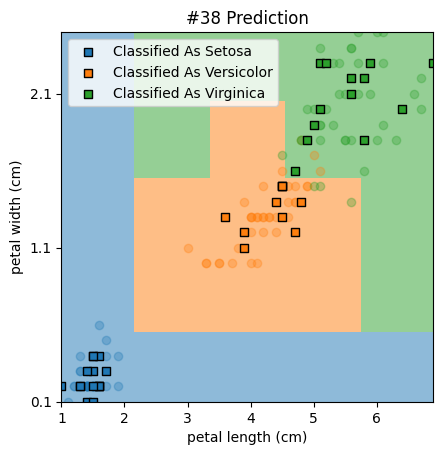

In [4]:
model_from_scratch = BernoulliNBFromScratch()

model_from_scratch.fit(X_train, y_train)

y_pred = model_from_scratch.predict(X_test, create_animation=True)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

In [5]:
X_train = X_train.drop(['petal length (cm)', 'petal width (cm)'], axis=1)
X_test = X_test.drop(['petal length (cm)', 'petal width (cm)'], axis=1)

In [6]:
model = BernoulliNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Accuracy Score: 0.9736842105263158
